In [13]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom
import os

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def read_results(p):
    df = pd.read_csv(p, sep='\t', index_col='Feature')
    return df

def unpack_hdi_and_filter(df, col):
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

#Add taxonomy data if it is missing from the biom table
#CHECK IF THE SPECIES ALREADY EXIST
def add_taxonomy_to_data(taxonomy,data):
    tax = pd.read_csv(taxonomy, sep = "\t", index_col = "Feature ID")
    dat = pd.read_csv(data, sep = "\t", index_col = "Feature")
    print(tax["Taxon"])
    dat['Taxon'] = tax["Taxon"]
    dat = dat.set_index("Taxon", drop = True)
    return dat

#Check if there are more than 20 features --> if so, only display top and bottom 10 
#Otherwise display all
def display_top_n_feats(df, n, yvar, xvar, xlab, ylab, title, output_folder):
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    sns.stripplot(data=df_for_display, y=yvar, x=xvar)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    f = xlab.split("Ratio for ")[1].split("T.")[1].rstrip("]").replace(" ", "_")
    #Figures will be autmatically saved in the output folder
    plt.savefig(output_folder + "/" + f, bbox_inches='tight')
    plt.show()

##This script prunes your taxonomy tree on the species level
def prune_taxonomy():
    df = pd.read_csv(taxonomy, sep = "\t", index_col = "Feature ID")
    pruned = []
    for tax in df["Taxon"]:
        pruned.append(tax.split("; s_")[0])
    df["Pruned Taxon"] = pruned
    df.to_csv("./birdman_data/pruned_taxonomy.tsv", sep = "\t")


In [15]:
# Replace the value with your own path. The dataset_name can be anything
dataset_name = "Cancer_Qiita"
result_filepath = '/home/btakacs/empress/birdman_data/cancer_qiita_metaanalysis_birdman_gibs_species_wo_breast_ffpe_vs_ff.beta_var.tsv'
taxonomy = "./birdman_data/taxonomy.tsv"
#This key needs to be the same as your dataset_name. The value is the variable(s) you're interested in, can be a string or a list
vars_to_check = {
    'Cancer_Qiita' : ['fixation_method[T.Fresh frozen]'] 
}
#Dictionary where your csv files and figures will be saved
output_folder = ""

This cell is skippable, it is there just to look at your file, to see if your table looks okay.

In [4]:
pd.read_csv(result_filepath, sep = "\t", index_col = "Feature")

,Intercept_mean,fixation_method[T.Fresh frozen]_mean,fixation_method[T.Other]_mean,tissue_type[T.colorectal]_mean,tissue_type[T.colorectal mucosa]_mean,tissue_type[T.easophagal mucosa]_mean,tissue_type[T.gastric]_mean,tissue_type[T.gastric mucosa]_mean,tissue_type[T.lung]_mean,tissue_type[T.pancreatic]_mean,...,Intercept_hdi,fixation_method[T.Fresh frozen]_hdi,fixation_method[T.Other]_hdi,tissue_type[T.colorectal]_hdi,tissue_type[T.colorectal mucosa]_hdi,tissue_type[T.easophagal mucosa]_hdi,tissue_type[T.gastric]_hdi,tissue_type[T.gastric mucosa]_hdi,tissue_type[T.lung]_hdi,tissue_type[T.pancreatic]_hdi
Feature,,,,,,,,,,,,,,,,,,,,,
AGTCAAGGACTACCAGGGTATCTAATCCTGTTTGATACCCACACTTTCGAGCATCAGTGTCAGTTGCAGTCCAGTGAGCTGCCTTCGCAATCGGAGTTCTTCGTGATATCTAAGCATTTCACCGCTACACCACGAATTCCGCCCACCTCT,-16.145175,-2.833870,1.458274,-1.174199,-2.252009,-0.190478,-1.104412,4.188662,-0.705773,-0.492569,...,"(-20.0952, -12.0318)","(-7.35733, 1.89539)","(-3.02329, 5.72398)","(-6.35626, 3.53263)","(-6.9136, 1.83477)","(-5.70139, 5.38018)","(-6.2563, 3.44342)","(-0.336028, 8.46925)","(-5.59315, 4.48455)","(-6.08195, 4.67565)"
AGGACTACCGGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGTCCCTCAGCGTCAGTATAGACCCAGTAAGCTGCCTTCGCCTTTGGTGTTCTTCCATATATCTACGCATTTCACCGCTTCACATGGAATTCCGCTTACCTCTATCCA,-16.786813,0.682902,-1.289620,-1.977294,-1.625820,-0.347418,3.507639,-0.428920,-1.373855,-0.283134,...,"(-20.7876, -12.4186)","(-3.61925, 4.76115)","(-5.96391, 3.65764)","(-6.65341, 2.49671)","(-6.67227, 2.91062)","(-5.46949, 4.95031)","(-0.588514, 7.36414)","(-5.46302, 4.94073)","(-5.98113, 3.30618)","(-5.48982, 5.1992)"
AGGACTACACGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGCACCTCAGCGTCAGTAATGGACCAGTAAGCCGCCTTCGCCACTGGTGTTCCTGCGAATATCTACGAATTTCACCTCTACACTCGCAATTCCACTTACCTCTTCCAT,-17.278192,-0.084772,-1.334363,-1.644489,-1.504924,-0.419485,2.524978,-0.593091,-1.079604,-0.335971,...,"(-21.2179, -13.2578)","(-4.34077, 3.52512)","(-6.18211, 3.21739)","(-6.23787, 3.02314)","(-6.27196, 3.26514)","(-6.11856, 4.59672)","(-1.72504, 6.47774)","(-6.03973, 4.71337)","(-6.1374, 3.60219)","(-5.78286, 5.17087)"
AAAACCTACGGGAGGCAGCAGTGAGGAATATTGGGCAATGGGCGAAAGCCTGACCCAGCAACGCCGCGTGGGGGATGAAGGCCTTCGGGTTGTAAACCCCTGTCGGAGGGGACGAGAGCCTTTCGGTTAATAGCCGGAAGGTGCGACGGT,-16.738412,-0.447510,-1.406873,2.525967,-1.494272,-0.455593,-1.335109,-0.576764,-1.094708,-0.430355,...,"(-21.1928, -12.5904)","(-4.60488, 4.3197)","(-5.80589, 3.30615)","(-1.29992, 6.60051)","(-6.58989, 2.50783)","(-5.98996, 4.80441)","(-5.88103, 3.55102)","(-6.0278, 4.41946)","(-6.54195, 3.53409)","(-5.67509, 4.50042)"
ACACTCCTGCGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCAACGCCGCGTGAGGGAAGACGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGACGAAGAAGTGACGGTAGCCAAGGAGGAAGCCACGGCT,-15.431471,-3.493155,-2.918435,-1.069483,2.334163,-0.171793,-1.260173,-0.444369,-0.675857,-0.693630,...,"(-19.3899, -11.852)","(-7.64516, 0.628074)","(-7.30619, 1.02741)","(-5.73475, 3.81798)","(-1.58036, 6.11917)","(-6.10802, 5.04419)","(-6.35531, 3.42421)","(-5.17453, 5.39972)","(-5.81361, 4.21334)","(-5.93648, 4.55635)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGGACTACCGGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGTACATGAGCGTCAGTATCGACCCAGGGGGCTGCCTTCGCCATCGGTATTCCTCCGCATATCTACGCATTTCACTGCTACACGCGGAATTCTACCCCCCTCTGCCGT,-16.634322,0.773998,-1.262605,-2.030906,-1.663149,-0.298755,3.567188,-0.462694,-1.387976,-0.433755,...,"(-20.9506, -12.4658)","(-3.00913, 4.93163)","(-6.33728, 3.72226)","(-6.80153, 2.2902)","(-6.14796, 2.76324)","(-5.53491, 5.47633)","(0.0980839, 7.61294)","(-5.69044, 4.85919)","(-5.95406, 3.33949)","(-6.1515, 4.41325)"
AGGACTACCGGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGTACCTCAGCGTCAACAGTCGTCCAGTGAGTCGCCTTCGCCACTGGTGTTCTTCCGAATATCTACGAATTTCACCTCTACACTCGGAATTCCACTCACCTCTCCGAC,-17.203380,0.125796,-1.377608,-1.824799,-1.359870,-0.384470,2.622148,-0.480629,-1.102828,-0.351084,...,"(-21.0907, -13.0761)","(-3.94178, 3.76378)","(-6.34529, 3.66475)","(-6.34775, 3.14628)","(-6.34542, 2.7199)","(-5.83058, 4.76416)","(-1.29206, 6.44252)","(-5.32177, 5.09

This is also skippable. You can check here if adding taxonomy to your table works. The taxonomy file comes from the sklearn classification of your data

In [11]:
add_taxonomy_to_data(taxonomy,result_filepath)

Feature ID
AAAACCTACGGGAGGCAGCAGTGAGGAATATTGGGCAATGGGCGAAAGCCTGACCCAGCAACGCCGCGTGGGGGATGAAGGCCTTCGGGTTGTAAACCCCTGTCGGAGGGGACGAGAGCCTTTCGGTTAATAGCCGGAAGGTGCGACGGT                                          k__Bacteria
AAAACCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGGTAGCCTGAACCAGCCAAGTAGCGTGAAGGATGAAGGCTCTATGGGTCGTAAACTTCTTTTATATAAGAATAAAGTGCAGTATGTATACTGTTTTGTATGTATTAT    k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
AAAACCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTTGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCCCCGGCTAAC    k__Bacteria; p__Firmicutes; c__Clostridia; o__...
AAAACCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAGGGAAGACGGTTTTCGGATTGTAAACCTCTGTTTTCGGTGACGAACAAATGACGGTAACCGAGTAGGAAGCCACGGCTA    k__Bacteria; p__Firmicutes; c__Clostridia; o__...
AAAACCTACGGGAGGCAGCAGTGGGGGATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAGGGAAGATGATGACGGTACCTGACTAAGAAGCCCCGGCTAAC    k__Bacteria; p__Fir

,Intercept_mean,fixation_method[T.Fresh frozen]_mean,fixation_method[T.Other]_mean,tissue_type[T.colorectal]_mean,tissue_type[T.colorectal mucosa]_mean,tissue_type[T.easophagal mucosa]_mean,tissue_type[T.gastric]_mean,tissue_type[T.gastric mucosa]_mean,tissue_type[T.lung]_mean,tissue_type[T.pancreatic]_mean,...,Intercept_hdi,fixation_method[T.Fresh frozen]_hdi,fixation_method[T.Other]_hdi,tissue_type[T.colorectal]_hdi,tissue_type[T.colorectal mucosa]_hdi,tissue_type[T.easophagal mucosa]_hdi,tissue_type[T.gastric]_hdi,tissue_type[T.gastric mucosa]_hdi,tissue_type[T.lung]_hdi,tissue_type[T.pancreatic]_hdi
Taxon,,,,,,,,,,,,,,,,,,,,,
NaN,-4.941824,1.247085,1.261864,-0.624012,-1.021933,-1.178767,1.555606,2.148096,-3.005880,-0.770580,...,"(-7.56037, -2.22964)","(-1.33224, 4.03657)","(-1.49651, 4.42872)","(-3.19846, 2.27432)","(-3.61553, 1.5274)","(-4.83684, 2.27648)","(-1.45091, 4.34107)","(-1.65015, 5.47367)","(-5.78927, 0.0321854)","(-4.6557, 3.46952)"
NaN,-4.284348,-1.400681,-0.570737,3.409033,2.585693,-0.121220,-4.935053,-6.026237,-0.634813,0.609269,...,"(-6.85131, -1.80043)","(-4.03759, 1.27115)","(-3.39617, 2.46353)","(0.522837, 5.99131)","(-0.0951225, 5.09631)","(-3.60617, 3.04317)","(-7.88269, -1.97317)","(-10.1184, -2.15097)","(-3.20617, 2.18084)","(-3.20576, 4.00632)"
NaN,-7.905887,-1.903135,-0.089332,4.561952,3.573078,3.498678,-2.046775,-4.210172,1.048030,-3.646283,...,"(-10.7101, -5.11361)","(-4.78047, 0.920714)","(-3.04541, 3.16289)","(1.64207, 7.2939)","(0.823634, 6.26398)","(-0.0932536, 7.16594)","(-5.60391, 1.04435)","(-8.34245, 0.00311259)","(-2.21499, 4.04015)","(-8.22577, 0.47024)"
NaN,-4.641016,-1.242645,-1.261687,1.788517,1.372838,0.335418,-3.787031,-5.335855,0.297778,-0.153433,...,"(-7.17453, -1.93073)","(-3.80672, 1.40753)","(-4.2893, 1.60635)","(-0.989023, 4.61679)","(-1.07061, 4.00168)","(-3.12487, 3.94746)","(-7.03247, -0.617092)","(-9.44537, -1.32817)","(-2.63897, 3.11025)","(-3.76995, 3.51518)"
NaN,-4.474296,-1.735543,-0.919573,3.084186,2.363069,1.732064,-3.406615,-5.750525,1.040805,0.698612,...,"(-7.13393, -1.88075)","(-4.3135, 0.889126)","(-3.83612, 2.19452)","(0.0525055, 5.65905)","(-0.353694, 4.76364)","(-1.82435, 5.20658)","(-6.49114, -0.080052)","(-9.66186, -1.6775)","(-1.51627, 3.98927)","(-2.90471, 4.31201)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,-16.139715,-0.013668,-2.428920,-2.112959,1.811970,-0.525130,-1.507072,-0.449353,-1.454878,-0.578863,...,"(-20.1191, -12.2722)","(-3.93191, 3.48649)","(-6.74069, 2.35088)","(-6.49278, 2.32104)","(-1.94997, 5.58776)","(-5.94411, 4.8135)","(-6.20202, 2.88777)","(-5.69176, 4.65418)","(-6.23127, 3.18503)","(-5.35775, 4.9356)"
NaN,-16.143697,0.569995,-2.611056,-2.288120,2.495209,-0.510809,-1.690404,-0.358019,-1.641641,-0.456091,...,"(-19.7983, -12.4167)","(-3.46283, 3.83893)","(-7.07306, 1.76121)","(-6.89148, 1.95815)","(-1.39119, 6.15659)","(-5.38216, 4.84803)","(-5.89744, 3.08326)","(-5.51839, 4.87381)","(-6.32667, 3.31426)","(-5.22751, 4.79753)"
NaN,-16.074320,0.207066,-2.405846,-2.220844,2.046508,-0.421984,-1.656947,-0.478356,-1.646896,-0.490747,...,"(-20.0872, -12.0403)","(-3.49375, 4.01118)","(-6.81008, 2.07815)","(-6.27997, 2.53799)","(-1.49033, 5.6154)","(-5.90097, 4.59322)","(-6.06889, 3.11577)","(-5.77051, 4.65734)","(-7.00468, 3.12737)","(-6.00123, 4.36741)"


Update the variable names

In [16]:
#Check if output_folder exists
#If not: create it
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

result_dict = {}
df = read_results(result_filepath)
#Uncomment this and comment out the one above if you want to add taxonomy
#df = add_taxonomy_to_data("/projects/cancer_qiita/btakacs/metaanalysis/mucosa_added_results/classification/taxonomy.tsv", result_filepath)
for v in vars_to_check: 
    if isinstance(vars_to_check[v],str):
        var = vars_to_check[v]
        print('Unfiltered Shape:  ' + str(df.shape))
        sub_df = unpack_hdi_and_filter(df, var+'_hdi')
        print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
        sub_df.rename_axis(index='Feature ID', inplace=True)
        if sub_df.loc[sub_df['credible'] == 'yes'].shape[0] != 0:
            result_dict[var] = sub_df.sort_values(by=var+'_mean')
            #Only the credible results will be saved to the csv file
            result_dict[var].to_csv(output_folder + f"/{var.split('T.')[1].rstrip(']').replace(' ', '_')}_filtered.tsv", sep = "\t")
    else:
        for var in vars_to_check[v]:
            print(var)
            print('Unfiltered Shape:  ' + str(df.shape))
            sub_df = unpack_hdi_and_filter(df, var+'_hdi')
            print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
            sub_df.rename_axis(index='Feature ID', inplace=True)
            if sub_df.loc[sub_df['credible'] == 'yes'].shape[0] != 0:
                result_dict[var] = sub_df.sort_values(by=var+'_mean')
                #Only the credible results will be saved to the csv file
                result_dict[var].to_csv(output_folder + f"/{var.split('T.')[1].rstrip(']').replace(' ', '_')}_filtered.tsv", sep = "\t")
                
print(result_dict.keys())

fixation_method[T.Fresh frozen]
Unfiltered Shape:  (10000, 24)
Filtered Shape: (1848, 27)
dict_keys(['fixation_method[T.Fresh frozen]'])


Create a graph for each variable

                                             Feature ID  Intercept_mean  \
0     ACACTCCTGCGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGC...      -13.290946   
1     ACTCCTGCGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAA...      -13.093727   
2     CACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCA...      -13.155657   
3     ACGTACACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGG...      -13.139015   
4     ACACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGC...      -13.183275   
...                                                 ...             ...   
2982  ACGTACACTCCTGCGGGAGGCAGCAGTGAGGAATATTGGTCAATGG...      -14.752169   
2983  ACGTACACTCCTGCGGGAGGCAGCAGTGGGGGATATTGCGCAATGG...      -14.752169   
2984  ACGTACACTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGG...      -14.752169   
2985  ACACTCCTGCGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGA...      -14.752169   
3484  CACTCCTGCGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAG...      -15.125360   

      fixation_method[T.Fresh frozen]_mean  tissue_type[T.colorectal]_mean  \
0                    

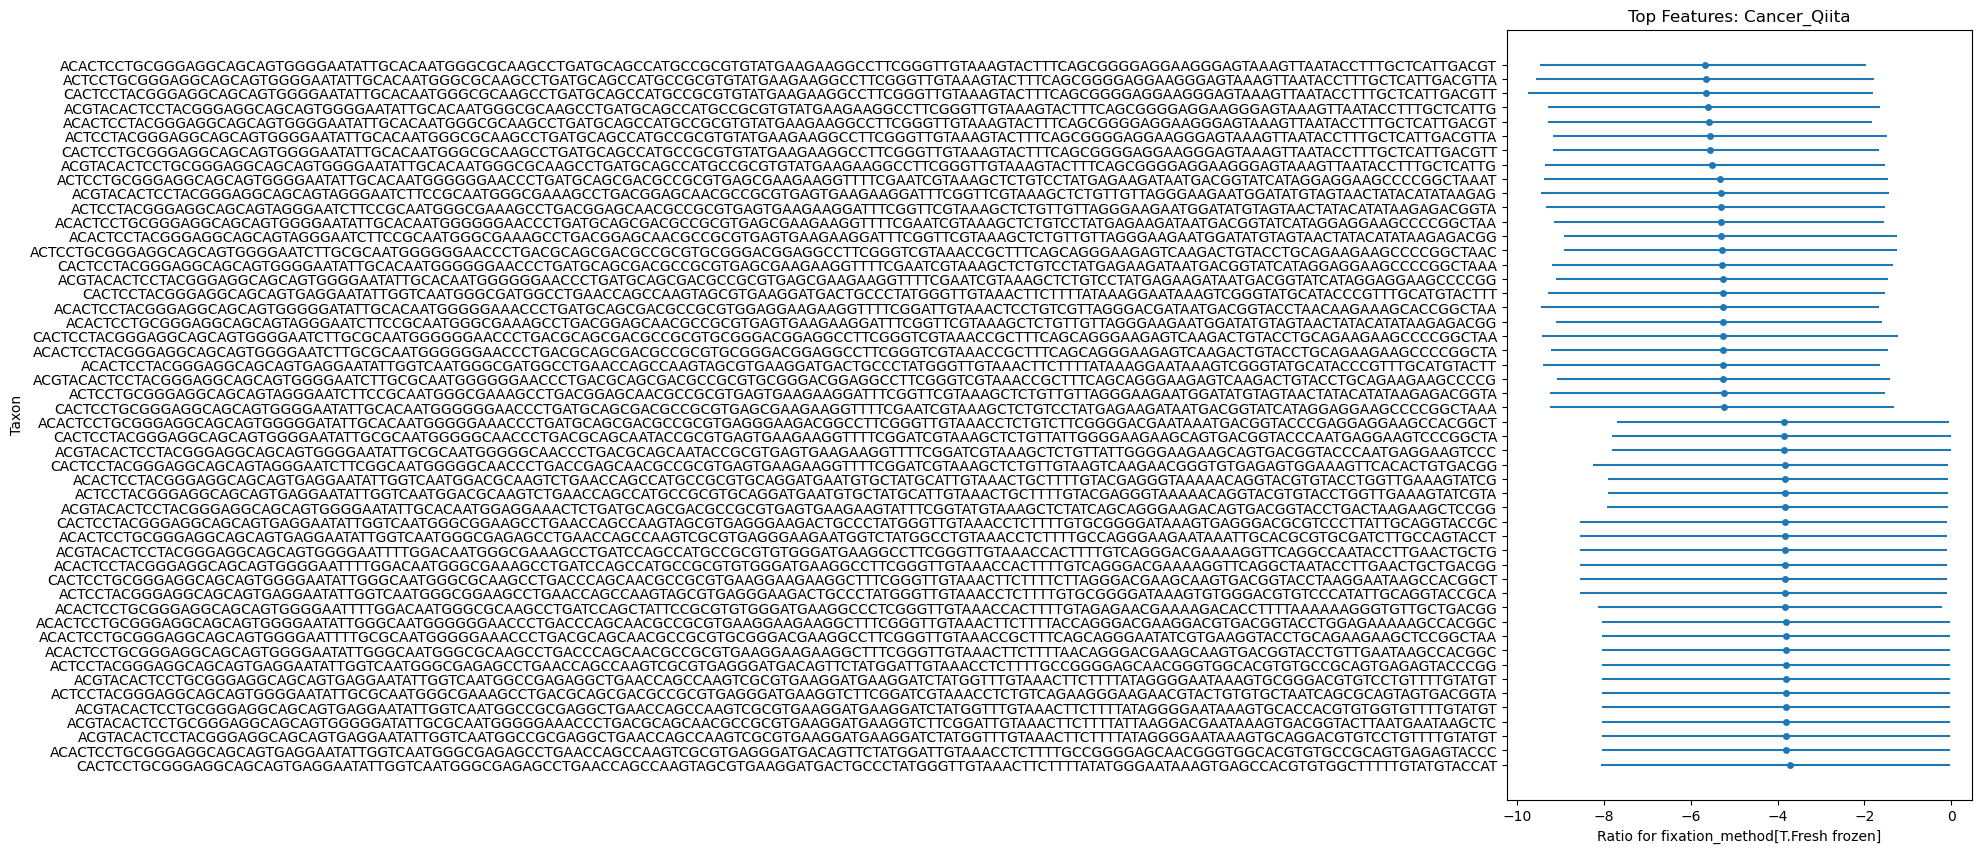

In [17]:
for k in result_dict.keys(): 
    xlab = 'Ratio for ' + k
    ylab = 'Taxon'
    df_for_display = result_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']
    fig, ax = plt.subplots(figsize=(6, 10))
    print(df_for_display)
    display_top_n_feats(df_for_display, 25, 'Feature ID', k+'_mean', xlab, ylab,
                                'Top Features: ' + dataset_name, output_folder)            

## Create empress plot

This assumes that your conda env has Qiime2 and Empress installed. Empress can be installed by running `pip install empress`

For further information, see the [Empress GitHub]("https://github.com/biocore/empress") repository

In [1]:
#Your feature table and sample-metadata should be the same ones that you used to perform the Birdman analysis. The feature-metadata files are your 
#taxonomy file and the output tsv file of this notebook.

!qiime empress community-plot \
    --i-tree birdman_data/sepp_rooted_tree.qza \
    --i-feature-table /projects/cancer_qiita/btakacs/metaanalysis/mucosa_added_results/02_02_feature_table_filtered_ffpe_or_fresh_frozen_wo_breast.qza \
    --m-sample-metadata-file birdman_data/11_29_meta_unfiltered.qza \
    --m-feature-metadata-file birdman_data/taxonomy.tsv \
    --m-feature-metadata-file filtered_birdman_species_ffpe_vs_ff/Fresh_frozen_filtered.tsv \
    --o-visualization birdman_data/fresh-frozen-tree-viz.qzv

# Alternately:
# !qiime empress tree-plot \
#     --i-tree fig2c/output/filtered-denovo-tree/rooted_tree.qza \
#     --m-feature-metadata-file fig2c/input/deblur-taxonomy.qza \
#     --m-feature-metadata-file fig2c/output/merged-diff-abund.tsv \
#     --o-visualization fig2c/output/tree-viz-just-fm.qzv

Saved Visualization to: birdman_data/fresh-frozen-tree-viz.qzv


### To visualize Birdman results and taxonomy together on the Empress plot:

* Change __Layout__ to Circular and make __Branch lengths__ ultrametric
* In __Barplots__ add new barplot, check __Color by__ and choose your Birdman feature, change __Color Map__ to one of the Diverging palettes (such as Red-Blue). Set __Distance between tree and barplots__ to 0. You can add multiple barplots to the same graph by clicking on __Add additional layer__. In this case make sure to choose different color palettes for different features!
- To add taxonomic coloring: in __Feature Metadata Coloring__ check __Color by__, choose a taxonomic level (reminder: Level 1 is Kingdom, Level 7 is species. Level 2, phylum is a good place to start imo). Make sure to use a Discrete color map
- __Export__ your figure and legends